In [1]:
import pandas as pd

# Path to your .rlrdata file
file_path = '51.rlrdata'

# Initialize lists to hold each column's data
years, sea_levels, letters, numbers = [], [], [], []

# Read the file
with open(file_path, 'r') as file:
    for line in file:
        # Split the line at semi-colons
        parts = line.strip().split(';')

        # Append data to respective lists
        years.append(int(parts[0].strip()))
        sea_levels.append(int(parts[1].strip()))
        # letters.append(parts[2].strip())
        # numbers.append(parts[3].strip())

# Create a DataFrame
data = pd.DataFrame({
    'Year': years,
    'Sea Level': sea_levels,
    #'Letter': letters,
    #'Number': numbers
})

# Write to CSV
csv_file_path = 'sea_level_data.csv'
data.to_csv(csv_file_path, index=False)

print(f"Data has been successfully converted to {csv_file_path}")


Data has been successfully converted to sea_level_data.csv


In [2]:
import pandas as pd

# Load the data
csv_file_path = 'sea_level_data.csv'
data = pd.read_csv(csv_file_path)

data.dropna(inplace=True)

print('Shape of data: ',data.shape)

data = data[data['Sea Level']!= -99999]


print('Shape of data: ',data.shape)

# Save the cleaned data back to CSV
cleaned_csv_file_path = 'cleaned_sea_level_data.csv'
data.to_csv(cleaned_csv_file_path, index=False)

print(f"Cleaned data has been saved to {cleaned_csv_file_path}")


Shape of data:  (137, 2)
Shape of data:  (119, 2)
Cleaned data has been saved to cleaned_sea_level_data.csv


## Handling Missing Values

 We interpolate the missing year, carrying forward the last known value, or leaving it as a gap if the analysis permits

In [3]:
## Data integrity

df = data.copy()

# Check for sequential years
df['Year_Diff'] = df['Year'].diff()
missing_years = df[df['Year_Diff'] > 1]['Year'] - 1
print(f"Missing years in the dataset: {missing_years.tolist()}")

# Basic Statistical Analysis
print(df['Sea Level'].describe())

# Interpolating missing years (optional)
# Assuming linear interpolation
df.set_index('Year', inplace=True)
df = df.reindex(range(df.index.min(), df.index.max() + 1))
df['Sea Level'].interpolate(inplace=True)

# Reset index if needed
df.reset_index(inplace=True)

# Check the dataset after interpolation
print(df)

Missing years in the dataset: [1889, 1924, 2003]
count     119.000000
mean     6842.403361
std       102.360970
min      6655.000000
25%      6767.500000
50%      6823.000000
75%      6903.500000
max      7099.000000
Name: Sea Level, dtype: float64
     Year  Sea Level  Year_Diff
0    1882     6740.0        NaN
1    1883     6823.0        1.0
2    1884     6772.0        1.0
3    1885     6754.0        1.0
4    1886     6755.0        1.0
..    ...        ...        ...
132  2014     6919.0        1.0
133  2015     6932.0        1.0
134  2016     6943.0        1.0
135  2017     6937.0        1.0
136  2018     6905.0        1.0

[137 rows x 3 columns]


In [4]:
df.head(15)

,Year,Sea Level,Year_Diff
0,1882,6740.0,NaN
1,1883,6823.0,1.0
2,1884,6772.0,1.0
3,1885,6754.0,1.0
4,1886,6755.0,1.0
5,1887,6744.0,1.0
6,1888,6902.0,1.0
7,1889,6786.5,NaN
8,1890,6671.0,2.0
9,1891,6726.0,1.0


Time Series Plot is used to observe trends, patterns, and potential anomalies over the years

---

 Histogram or density plot is used to understand the distribution of sea level measurements.

 ---
 Box plot can provide insights into the quartiles of the data and identify any outliers


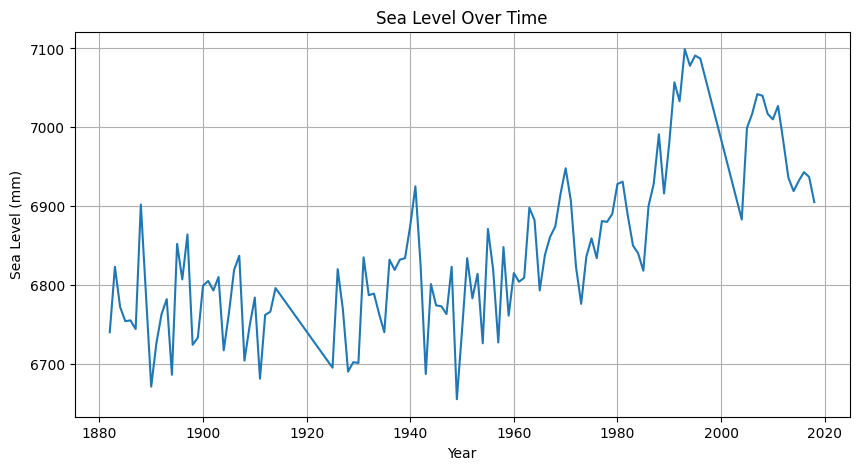

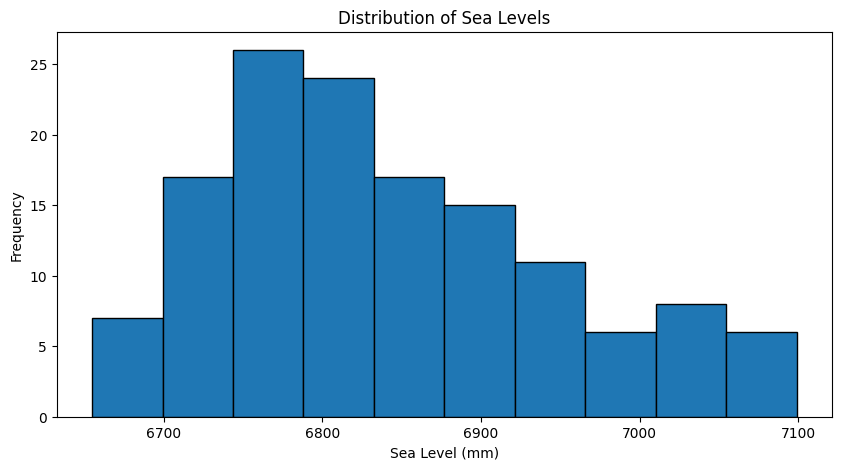

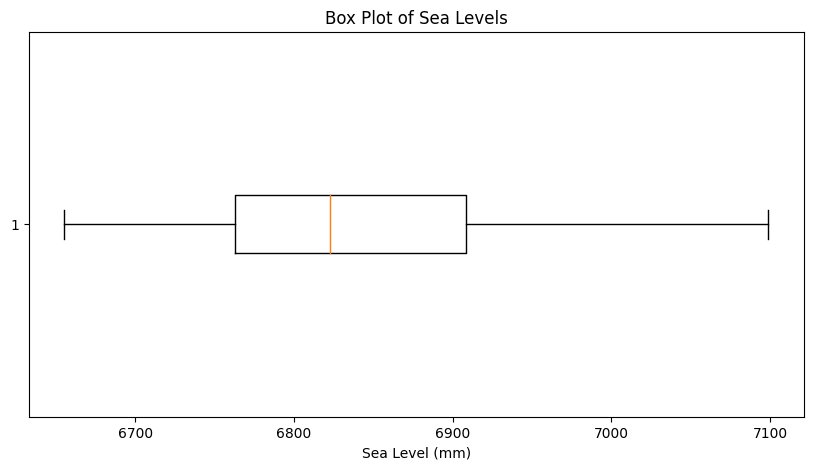

In [5]:
import matplotlib.pyplot as plt

# Time Series Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['Sea Level'])
plt.title('Sea Level Over Time')
plt.xlabel('Year')
plt.ylabel('Sea Level (mm)')
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(df['Sea Level'], bins=10, edgecolor='black')
plt.title('Distribution of Sea Levels')
plt.xlabel('Sea Level (mm)')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.figure(figsize=(10, 5))
plt.boxplot(df['Sea Level'], vert=False)
plt.title('Box Plot of Sea Levels')
plt.xlabel('Sea Level (mm)')
plt.show()

# ARIMA

ARIMA models require the data to be stationary. We can use the Augmented Dickey-Fuller test to check for stationarity:

In [6]:
from statsmodels.tsa.stattools import adfuller

df.set_index('Year', inplace=True)

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

check_stationarity(df['Sea Level'])

ADF Statistic: -1.997174
p-value: 0.287814
Series is not stationary


We'll apply differencing to your dataset to make it stationary. This is essentially what the 'Integrated (I)' part of ARIMA does. For simplicity, we'll start with a first difference, but you might need to experiment with the degree of differencing.

In [7]:
# Differencing the data
df_diff = df['Sea Level'].diff().dropna()

# Check stationarity again
check_stationarity(df_diff)

ADF Statistic: -8.461493
p-value: 0.000000
Series is stationary


We will split the data into training and testing sets. Let's use the first 80% of the data for training and the remaining 20% for testing:

In [8]:
split = int(len(df_diff) * 0.8)
train_diff = df_diff[:split]
test_diff = df_diff[split:]

In [9]:
df_diff

Year
1883    83.0
1884   -51.0
1885   -18.0
1886     1.0
1887   -11.0
        ... 
2014   -17.0
2015    13.0
2016    11.0
2017    -6.0
2018   -32.0
Name: Sea Level, Length: 136, dtype: float64

Now, we train the ARIMA model. We'll use a simple ARIMA model without hyperparameter tuning for now

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Train the ARIMA model
model_diff = ARIMA(train_diff, order=(1, 1, 1))  # Adjust p and q as necessary
fitted_model_diff = model_diff.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We can evaluate the model's performance on the test set

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


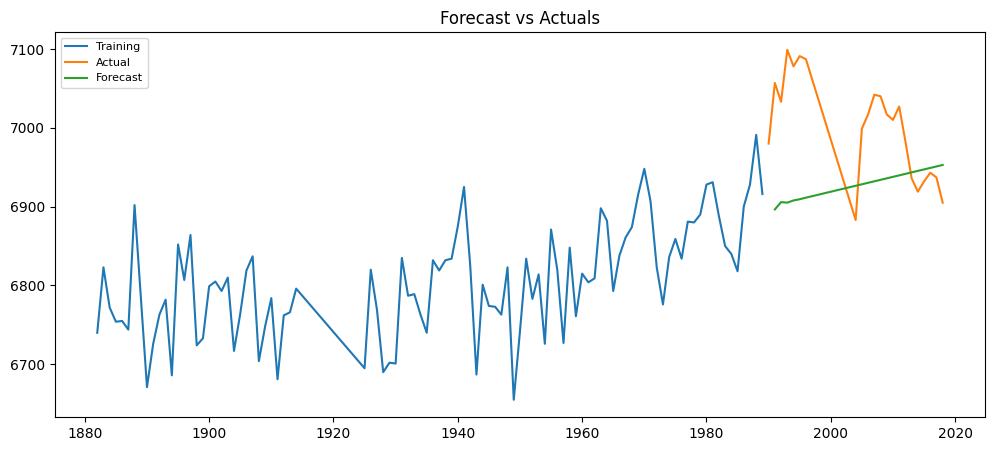

In [11]:
# Forecast
fc_diff = fitted_model_diff.forecast(len(test_diff), alpha=0.05)  # 95% confidence

# Revert differencing to get actual forecast
fc_series_diff = pd.Series(fc_diff.values, index=test_diff.index)
fc_series_diff_cumulative = fc_series_diff.cumsum() + df['Sea Level'].iloc[split-1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Sea Level'][:split], label='Training')
plt.plot(df['Sea Level'][split:], label='Actual')
plt.plot(fc_series_diff_cumulative, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Hyperparameter Tuning

We can fine-tune the parameters (p, d, q) of the ARIMA model to optimize performance. This can be done using grid search or by analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

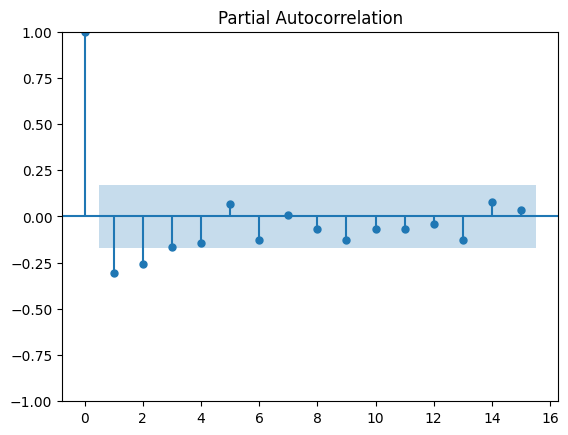

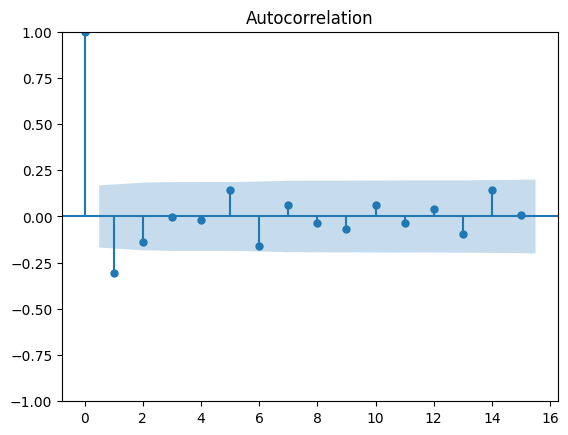

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF and ACF plots
plot_pacf(df_diff, lags=15)
plot_acf(df_diff, lags=15)
plt.show()

After getting an idea about p and q from the ACF and PACF plots, we can perform a grid search to find the optimal set of parameters. This involves trying different combinations of p, d, q, and comparing the models based on a criterion like AIC (Akaike Information Criterion).

In [13]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)  # Define the range for p, d, q
pdq = list(itertools.product(p, d, q))  # All combinations of p, d, q

warnings.filterwarnings("ignore")  # Ignore warning messages
best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        mod = ARIMA(train_diff, order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print(f"Best ARIMA Model: {best_pdq} with AIC: {best_aic}")

Best ARIMA Model: (1, 1, 2) with AIC: 1173.9996098204444


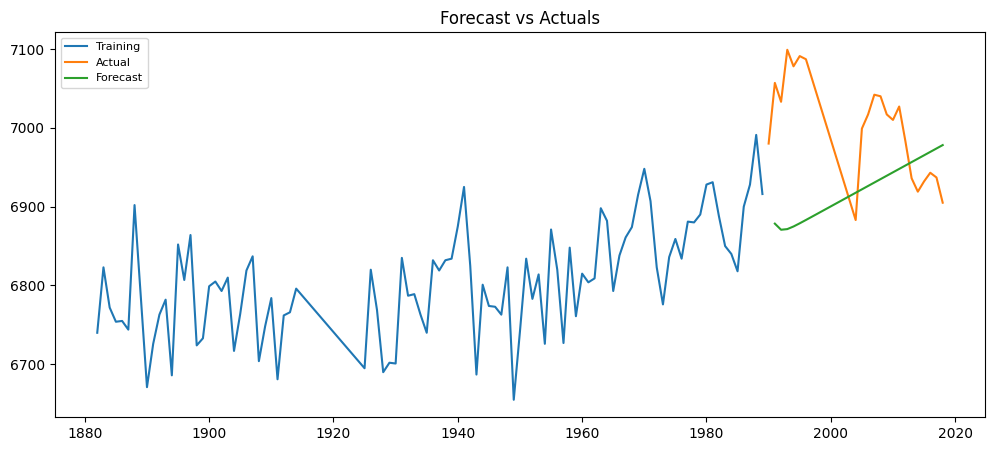

In [14]:
# Train the ARIMA model
model_diff = ARIMA(train_diff, order=(1, 1, 2))  # Adjust p and q as necessary
fitted_model_diff = model_diff.fit()

# Forecast
fc_diff = fitted_model_diff.forecast(len(test_diff), alpha=0.05)  # 95% confidence

# Revert differencing to get actual forecast
fc_series_diff = pd.Series(fc_diff.values, index=test_diff.index)
fc_series_diff_cumulative = fc_series_diff.cumsum() + df['Sea Level'].iloc[split-1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Sea Level'][:split], label='Training')
plt.plot(df['Sea Level'][split:], label='Actual')
plt.plot(fc_series_diff_cumulative, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# SARIMA

Implementing a Seasonal ARIMA (SARIMA) model involves similar steps to ARIMA, but with additional parameters to account for seasonality. SARIMA is particularly useful if your data exhibits seasonal patterns. The SARIMA model is denoted as SARIMA(p, d, q)(P, D, Q)s, where (P, D, Q) are the seasonal parts of the model and 's' is the periodicity of the time series.

In [15]:
df_sarima = df[['Sea Level']]
split = int(len(df_sarima) * 0.8)
train = df_sarima[:split]
test = df_sarima[split:]

Train the SARIMA model. Initially, we choose arbitrary values for the SARIMA parameters.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Adjust these parameters
fitted_model = model.fit()


Evaluate the model's performance on the test set

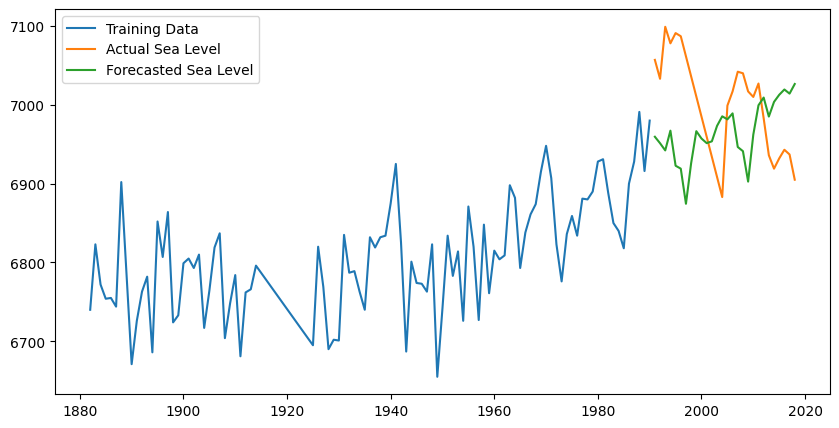

In [17]:
# Forecast
fc = fitted_model.forecast(len(test))
test['Forecast'] = fc.values

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train['Sea Level'], label='Training Data')
plt.plot(test['Sea Level'], label='Actual Sea Level')
plt.plot(test['Forecast'], label='Forecasted Sea Level')
plt.legend()
plt.show()


## Hyperparameter Tuning

In [20]:
p = d = q = range(1, 3)  # Non-seasonal parameters
P = D = Q = range(1, 3)  # Seasonal parameters
s = 12  # Assuming annual seasonality for monthly data; adjust based on your data frequency

# Generate all different combinations of p, q, d, P, D, and Q
from itertools import product
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(P, D, Q))]

In [21]:
len(seasonal_pdq)

8

**Computational Time:** SARIMAX grid search can be time-consuming, especially for larger parameter spaces.

**Model Convergence:** Not all parameter combinations will converge. The warnings filter is used to ignore convergence warnings.

**AIC for Model Selection:** Lower AIC values generally indicate a better model, balancing model complexity against goodness of fit.

**Data Frequency (s):** Make sure to set the seasonal period (s) correctly based on the frequency of your data.

**Model Overfitting:** Be cautious of overfitting, especially with complex models on small datasets. Consider additional evaluation metrics like the BIC or cross-validation methods if necessary.

In [22]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

warnings.filterwarnings("ignore")  # Suppress warnings for model convergence issues

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_results = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_results = results
        except:
            continue

print(f"Best SARIMAX model: ARIMA{best_pdq} x {best_seasonal_pdq} with AIC: {best_aic}")


Best SARIMAX model: ARIMA(2, 2, 2) x (2, 1, 2, 12) with AIC: 92.87543068499195


# LSTM

Implementing a Long Short-Term Memory (LSTM) network for time series forecasting involves several steps, especially for preprocessing and structuring the data appropriately. LSTM networks are a type of recurrent neural network (RNN) that are particularly well-suited for sequential data like time series


In [28]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming 'df' is your DataFrame and 'Sea Level' is the column of interest
data = df['Sea Level'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Create sequences of a specific number of time steps (let's say n_steps) and the corresponding output.

In [48]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps (can be tuned)
X, y = create_sequences(scaled_data, n_steps)


Split the data into training and testing sets. It's important to maintain the order of the data for time series.

In [31]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Build and train an LSTM model.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
4/4 [==============================] - 4s 8ms/step - loss: 0.1315
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0985
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0679
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0429
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0275
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 12/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 13/100
4/4 [==============================] - 0s 7ms/st

Use the test set to evaluate the model's performance.

In [33]:
# Making predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Revert scaling

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(scaler.inverse_transform(y_test), predicted)
print(f'MSE: {mse}')

1/1 [==============================] - 2s 2s/step
MSE: 2427.252642110542


Use the model to forecast future values.

In [34]:
# Forecasting future values
# Use the last n_steps values from your data to predict the next step
last_sequence = scaled_data[-n_steps:]
last_sequence = last_sequence.reshape(1, n_steps, 1)

future_forecast_scaled = model.predict(last_sequence)
future_forecast = scaler.inverse_transform(future_forecast_scaled)
print(f'Future Sea Level: {future_forecast}')


1/1 [==============================] - 0s 32ms/step
Future Sea Level: [[6917.5063]]


## Hyperparameter Tuning

Tuning parameters like the number of LSTM units, batch size, number of epochs, and the number of layers can significantly affect model performance. This typically involves experimenting with different values to find the optimal configuration.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape, units, layers, lr):
    model = Sequential()
    model.add(LSTM(units, return_sequences=(layers > 1), input_shape=input_shape))
    for i in range(1, layers):
        model.add(LSTM(units, return_sequences=(i < layers - 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model


Loop over the range of values for each hyperparameter. Fit the model on the training set and evaluate it on the validation set. Due to computational constraints, we'll demonstrate with a simplified version

In [36]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming X_train, y_train are already defined
input_shape = (X_train.shape[1], 1)
kf = KFold(n_splits=3)

best_score = float('inf')
best_params = {}

for units in [50, 100]:
    for layers in [1, 2]:
        for lr in [0.001, 0.01]:
            scores = []
            for train_index, test_index in kf.split(X_train):
                X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
                y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

                model = build_lstm_model(input_shape, units, layers, lr)
                model.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)
                scores.append(model.evaluate(X_test_kf, y_test_kf, verbose=0))

            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_params = {'units': units, 'layers': layers, 'lr': lr}

print(f"Best Parameters: {best_params}, Score: {best_score}")

Best Parameters: {'units': 100, 'layers': 1, 'lr': 0.001}, Score: 0.028691307331124943


Build and train an LSTM model using optimized hyperparameters

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Building the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(n_steps, 1)))  # 100 units, 1 layer
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
4/4 [==============================] - 4s 9ms/step - loss: 0.1321
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0926
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0605
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0389
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0244
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0234
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0238
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0202
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 13/100
4/4 [==============================] - 0s 12m

In [41]:
test

,Sea Level,Forecast,predicted_mean
Year,,,
1991,7057.0,5.899906e+15,NaN
1992,7033.0,6.106964e+15,NaN
1993,7099.0,6.242282e+15,NaN
1994,7078.0,6.451763e+15,NaN
1995,7091.0,6.668714e+15,NaN
1996,7087.0,6.840241e+15,NaN
1997,7061.5,7.066632e+15,NaN
1998,7036.0,7.287407e+15,NaN
1999,7010.5,7.479579e+15,NaN


Use the model to make predictions on the test data

In [50]:
# Making predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # If data was scaled

# Add the predictions to the test DataFrame
test.drop(test.tail(1).index,inplace=True)
test['predicted_mean'] = np.concatenate(predicted)

1/1 [==============================] - 0s 37ms/step


Plot the training data, actual test data, and the predicted values

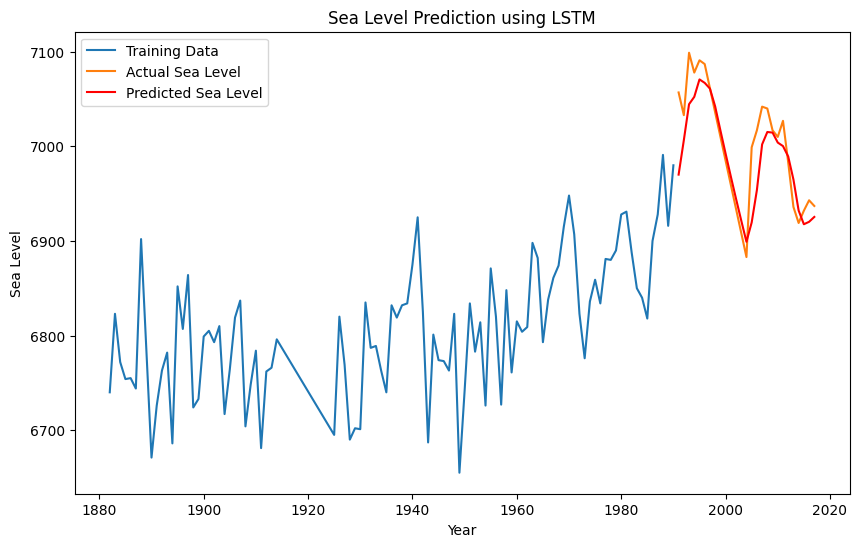

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train['Sea Level'], label='Training Data')
plt.plot(test['Sea Level'], label='Actual Sea Level')
plt.plot(test.index, test['predicted_mean'], label='Predicted Sea Level', color='r')
plt.title('Sea Level Prediction using LSTM')
plt.xlabel('Year')
plt.ylabel('Sea Level')
plt.legend()
plt.show()


# XGBoost

For XGBoost, we need to create lag features that will act as predictors. We'll create a function to generate these lag features based on the number of lags you want to include.

In [52]:
def create_lag_features(data, n_lags):
    df = pd.DataFrame(data)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['Sea Level'].shift(i)
    df.dropna(inplace=True)
    return df

# Number of lags (this is a hyperparameter you can tune)
n_lags = 3
df_lagged = create_lag_features(df['Sea Level'], n_lags)


Split the dataset into training and testing sets. It's important to preserve the time order in the data.

In [53]:
split = int(len(df_lagged) * 0.8)
train = df_lagged[:split]
test = df_lagged[split:]

X_train = train.drop('Sea Level', axis=1)
y_train = train['Sea Level']
X_test = test.drop('Sea Level', axis=1)
y_test = test['Sea Level']


Train an XGBoost model on the training dataset.


In [54]:
import xgboost as xgb

model = xgb.XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


Evaluate the model's performance using a suitable metric, like RMSE (Root Mean Squared Error)

In [55]:
from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


RMSE: 78.28494159236827



XGBoost has several hyperparameters that can be tuned to improve performance. You can use grid search or random search to find the best combination. Some important hyperparameters include learning_rate, max_depth, n_estimators, subsample, and colsample_bytree.

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}



Use the best model to forecast future values. Here, you need to prepare the input data in the same format as the model expects (including lags).

In [57]:
# Prepare the most recent data point with lags
most_recent_data = df_lagged.iloc[-n_lags:].drop('Sea Level', axis=1)

# Predict the next value
next_value_prediction = best_grid.predict(most_recent_data)
print(f"Next value forecast: {next_value_prediction[0]}")


Next value forecast: 6938.44677734375


In [58]:
# Use the best model from hyperparameter tuning to predict the test data
test_predictions = best_grid.predict(X_test)

Plot the training data, actual test data, and the predicted values for comparison

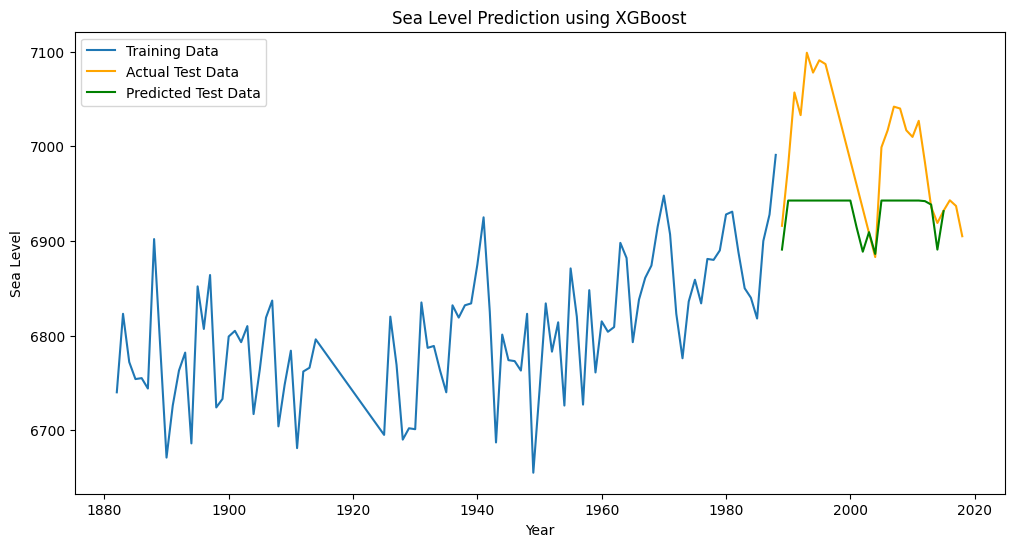

In [60]:
import matplotlib.pyplot as plt

# Assuming the original 'df' DataFrame has the complete 'Sea Level' data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(df.index[:split], df['Sea Level'][:split], label='Training Data')

# Plot actual test data
plt.plot(df.index[split:], df['Sea Level'][split:], label='Actual Test Data', color='orange')

# Plot predicted test data
# Adjust the test data indices based on your DataFrame
plt.plot(df.index[split:split + len(test_predictions)], test_predictions, label='Predicted Test Data', color='green')

plt.title('Sea Level Prediction using XGBoost')
plt.xlabel('Year')
plt.ylabel('Sea Level')
plt.legend()
plt.show()
